In [1]:
%matplotlib inline

In [2]:
import sklearn
import xgboost
import vecstack
import dill

/usr/local/lib/python2.7/dist-packages/scipy/sparse/lil.py:16: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import _csparsetools
/usr/local/lib/python2.7/dist-packages/scipy/sparse/csgraph/__init__.py:167: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._shortest_path import shortest_path, floyd_warshall, dijkstra,\
/usr/local/lib/python2.7/dist-packages/scipy/sparse/csgraph/_validation.py:5: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._tools import csgraph_to_dense, csgraph_from_dense,\
/usr/local/lib/python2.7/dist-packages/scipy/sparse/csgraph/__init__.py:169: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ._traversal import breadth_first_order, depth_first_order, \
/usr/local/lib/python2.7/dist-packages/scipy/sparse/csgraph/__init__.py:171: R

In [3]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
def read_df(filename, valtype):
    df = pd.read_csv(filename, low_memory=False, dtype=valtype)
    return df

In [5]:
from collections import OrderedDict, defaultdict

def create_combined_df(input_dict):
    fdf = pd.DataFrame()
    cols = OrderedDict()
    for k, v in input_dict.items():
        df = read_df('./data/'+k, v)
        colnames = [c for c in df.columns if c not in ['None', 'Unnamed: 0']]
        cols[k] = colnames
        fdf = pd.concat([fdf, df], axis=1)
    
    # fdf = fdf.DataFrame(fdf, columns=cols)
    fdf = fdf.drop(['None', 'Unnamed: 0'], axis=1)
    return fdf, cols

# Read Dependent feature data

In [6]:
base = './data/'

In [8]:
y_train = pd.read_csv(base+'fin_train_indeps.csv', encoding='utf8')
y_train = y_train.drop(['Unnamed: 0'], axis=1)
y_train.sample()

,review_scores_rating
108738,96.0


In [9]:
y_test = pd.read_csv(base+'fin_test_indeps.csv', encoding='utf8')
y_test = y_test.drop(['Unnamed: 0'], axis=1)
y_test.sample()

,review_scores_rating
8466,87.0


# Permute y_test

In [10]:
y_train_perm = y_train.sample(frac=1)
y_test_perm = y_test.sample(frac=1)

# Read independent feature data

In [11]:
comb_train = pd.read_csv(base+'fin_comb_train_deps.csv')
comb_train = comb_train.drop(['Unnamed: 0'], axis=1)
comb_test = pd.read_csv(base+'fin_comb_test_deps.csv')
comb_test = comb_test.drop(['Unnamed: 0'], axis=1)

In [12]:
comb_train.columns


Index([u'bathrooms', u'bedrooms', u'beds', u'cleaning_fee', u'guests_included',
       u'host_listings_count', u'host_acceptance_rate', u'host_response_rate',
       u'host_has_profile_pic', u'host_identity_verified',
       ...
       u'amenities_smartlock', u'amenities_smokedetector',
       u'amenities_smokingallowed', u'amenities_suitableforevents',
       u'amenities_translationmissingenhostingamenity', u'amenities_tv',
       u'amenities_washer', u'amenities_wheelchairaccessible',
       u'amenities_wifi', u'amenities_wirelessinternet'],
      dtype='object', length=195)

In [37]:
keeps = ['amenities', 'cleaning_fee', 'host_', 'bed_type', 'guests_']
notkeeps = ['neighbourhood', 'property', 'bathrooms', 'bedrooms', 'gym', 'parking', 
            'elevator', 'nan', 'bathtub', 'fireplace', 'translation']

some = set([])
for c in comb_train.columns:
    for k in keeps:
        if k in c:
            some.add(c)
someless = set([])
for c in comb_train.columns:
    for nk in notkeeps:
        if nk in c:
            someless.add(c)
cols = some - someless
cols = list(cols)
# set(some) - set(someless)

In [38]:
comb_train = comb_train[cols]
comb_test = comb_test[cols]
comb_train.sample()

,amenities_familykidfriendly,amenities_carbonmonoxidedetector,amenities_airconditioning,amenities_hairdryer,bed_type_real_bed,host_has_profile_pic,host_response_time_a_few_days_or_more,host_response_time_within_an_hour,amenities_cats,amenities_dishwasher,...,cleaning_fee,amenities_lockonbedroomdoor,host_response_time_within_a_day,amenities_laptopfriendlyworkspace,amenities_keypad,guests_included,amenities_hottub,amenities_longtermstaysallowed,amenities_wirelessinternet,bed_type_pull_out_sofa
81652,1,1,0,1,1,1.0,0,1,1,0,...,0.125,0,0,1,1,0.0,0,0,1,0


# Split Test data into Holdout and Validation sets

In [39]:
# Objective: Implement a wrapper for vecstack
# Input scikit model instances and training data
# Output: Predictions

import xgboost
import dill as pickle
from copy import deepcopy 
from vecstack import StackingTransformer
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.externals import joblib

class VecstackRunner():

    def __init__(self, X, y, Xt, yt, l1_estimators, l2_estimator, prfx='', metric='rmse', regression=True, nfolds=10, verbose=2):
        self.X = X
        self.y = y
        self.Xt = Xt
        self.yt = yt
        self.yp = None
        self.ytp = None
        self.l1 = l1_estimators
        self.l2 = l2_estimator
        self.prfx = prfx
        self.metname = metric
        self.nf = nfolds
        self.v = verbose
        self.is_reg = regression
        self.stack = None
    
    def mse(self, actual, pred):
        return mean_squared_error(actual, pred)
    
    def rsq(self, actual, pred):
        return r2_score(actual, pred)
    
    def get_metric_calc(self, actual, pred):
        if 'rmse' == self.metname:
            return self.mse(actual, pred)
        elif 'r2' == self.metname:
            return self.rsq(actual, pred)
    
    def build_stack(self):
        self.stack = StackingTransformer(self.l1, 
                                        regression=self.is_reg, 
                                        shuffle=True, 
                                        n_folds=self.nf, 
                                        metric=self.get_metric_calc, 
                                        verbose=self.v)
    
    def fit_stack(self):
        return self.stack.fit(self.X, self.y)
    
    def transform(self):
        self.X = self.stack.transform(self.X)
        self.Xt = self.stack.transform(self.Xt)
    
    def fit_l2(self):
        self.l2.fit(self.X, self.y)
    
    def predict(self):
        self.yp = self.l2.predict(self.X)
        self.ytp = self.l2.predict(self.Xt)
    
    def calculate_error(self, calc=None):
        if calc:
            y_err = calc(self.y, self.yp)
            yp_err = calc(self.y, self.ytp)
        else:
            y_err = self.get_metric_calc(self.y, self.yp)
            yt_err = self.get_metric_calc(self.yt, self.ytp)
            
        return [('Train err', y_err), ('Test err', yt_err)]
    
    def save_to_disk(self):
        sname = self.prfx+'_vecstack_stack.pkl'
        cname = self.prfx+'_vecstack_clf.pkl'
        
        with open('./data/'+sname, 'wb') as f:
            pickle.dump(self.stack,f)
        
        with open('./data/'+cname, 'wb') as f:
            pickle.dump(self.l2, f)
    
    def run(self):
        self.build_stack()
        self.fit_stack()
        self.transform()
        self.fit_l2()
        self.predict()
        self.save_to_disk()
        return self.calculate_error()

In [40]:
from sklearn.linear_model import ElasticNet, Lasso, Ridge
from sklearn.ensemble import AdaBoostRegressor, GradientBoostingRegressor, RandomForestRegressor
from sklearn.svm import SVR

en = ElasticNet(alpha=0.01)
# lass = Lasso(alpha=0.001, fit_intercept=False, max_iter=1000)
ridge = Ridge(normalize=False, alpha=0.1, max_iter=1000)
gb = GradientBoostingRegressor(n_estimators=100, learning_rate=0.01, 
                               subsample=0.75, max_depth=15)
ab = AdaBoostRegressor(n_estimators=100, learning_rate=0.01)
xgb = xgboost.XGBRegressor(n_estimators=100, learning_rate=0.05, 
                           gamma=0, subsample=0.5, 
                           max_depth=15, objective='reg:linear')
randf = RandomForestRegressor(n_estimators=100, min_samples_split=10)
svr_rbf = SVR(kernel='rbf')

/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/base.py:35: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils.seq_dataset import ArrayDataset, CSRDataset
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/least_angle.py:23: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from ..utils import arrayfuncs, as_float_array, check_X_y, deprecated
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/coordinate_descent.py:29: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from . import cd_fast
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/__init__.py:22: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  from .sgd_fast import Hinge, Log, ModifiedHuber, SquaredLoss, Huber
/usr/local/lib/python2.7/dist-packages/sklearn/linear_model/sag.py

In [41]:
from copy import deepcopy

In [43]:
estimators = [
                ('en', en), 
                # ('lass', lass), 
                ('ridge', ridge),
                ('gb', gb), 
                ('ab', ab), 
                ('randf', randf), 
             ]
base = './data/'
prf = 'user'
vr = VecstackRunner(comb_train, y_train, 
                    comb_test, y_test, 
                    estimators, xgb, prfx=prf, nfolds=10)
vr.run()

# print mean_squared_error(y_validation, tc.predict(ts.transform(comb_validation)))

/usr/local/lib/python2.7/dist-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


task:         [regression]
metric:       [get_metric_calc]
variant:      [A]
n_estimators: [5]

estimator  0: [en: ElasticNet]
    fold  0:  [23.76217190]
    fold  1:  [23.09347796]
    fold  2:  [23.65695901]
    fold  3:  [23.32847785]
    fold  4:  [23.70200937]
    fold  5:  [23.54772634]
    fold  6:  [23.11553599]
    fold  7:  [23.85422414]
    fold  8:  [23.80202080]
    fold  9:  [23.00813026]
    ----
    MEAN:     [23.48707336] + [0.30592558]

estimator  1: [ridge: Ridge]
    fold  0:  [23.54659220]
    fold  1:  [23.02767930]
    fold  2:  [23.52472992]
    fold  3:  [23.09643617]
    fold  4:  [23.59304036]
    fold  5:  [23.38988161]
    fold  6:  [22.94831419]
    fold  7:  [23.65149062]
    fold  8:  [23.67027338]
    fold  9:  [22.76995174]
    ----
    MEAN:     [23.32183895] + [0.31326859]

estimator  2: [gb: GradientBoostingRegressor]
    fold  0:  [14.73387192]
    fold  1:  [14.24435589]
    fold  2:  [14.39881298]
    fold  3:  [14.31148176]
    fold  4:  [14.29

[('Train err', 5.869588103934944), ('Test err', 6.839370096936715)]

In [45]:
import dill as pickle

base='./data/'
prf='user'
with open(base+prf+'_vecstack_stack.pkl', 'rb') as f:
    ts = pickle.load(f)

with open(base+prf+'_vecstack_clf.pkl', 'rb') as f:
    tc = pickle.load(f)

In [46]:
Xt = ts.transform(comb_train)
Xp = tc.predict(Xt)
y = y_train

Train set was detected.
Transforming...

estimator  0: [en: ElasticNet]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
    model from fold  8: done
    model from fold  9: done
    ----
    DONE

estimator  1: [ridge: Ridge]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
    model from fold  8: done
    model from fold  9: done
    ----
    DONE

estimator  2: [gb: GradientBoostingRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
   

In [47]:
Xvt = ts.transform(comb_test)
Xvp = tc.predict(Xvt)
yv = y_test

Transforming...

estimator  0: [en: ElasticNet]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
    model from fold  8: done
    model from fold  9: done
    ----
    DONE

estimator  1: [ridge: Ridge]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
    model from fold  8: done
    model from fold  9: done
    ----
    DONE

estimator  2: [gb: GradientBoostingRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
    model from fold  8: don

In [61]:
from sklearn.metrics import mean_squared_error, r2_score
print '####################'
print 'Column: %s' % prf
print 'Train: '
train_act_mse = mean_squared_error(y, Xp)
print 'MSE: %s' % train_act_mse
train_act_r2 = r2_score(y, Xp)
print 'R2: %s' % train_act_r2

print 'Train Perm: '
print 'MSE: %s' % mean_squared_error(y_train_perm, Xp)
print 'R2: %s' % r2_score(y_train_perm, Xp) 

####################
Column: user
Train: 
MSE: 5.869588103934944
R2: 0.768863253635279
Train Perm: 
MSE: 44.08381894021237
R2: -0.7390985009498281


In [70]:
tc.feature_importances_

array([0.30585775, 0.1654041 , 0.20044044, 0.14974675, 0.17855097],
      dtype=float32)

In [65]:
Xvt = ts.transform(comb_test)
Xvp = tc.predict(Xvt)
yv = y_test
print yv.shape
print Xvp.shape

Transforming...

estimator  0: [en: ElasticNet]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
    model from fold  8: done
    model from fold  9: done
    ----
    DONE

estimator  1: [ridge: Ridge]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
    model from fold  8: done
    model from fold  9: done
    ----
    DONE

estimator  2: [gb: GradientBoostingRegressor]
    model from fold  0: done
    model from fold  1: done
    model from fold  2: done
    model from fold  3: done
    model from fold  4: done
    model from fold  5: done
    model from fold  6: done
    model from fold  7: done
    model from fold  8: don

ValueError: y_true and y_pred have different number of output (2!=1)

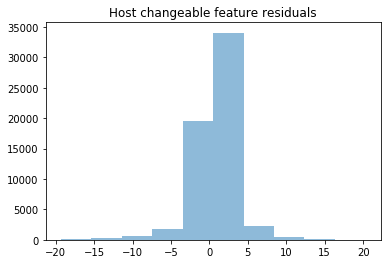

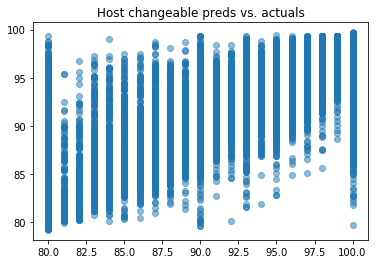

In [77]:
plt.hist(y_test.review_scores_rating - Xvp, alpha=0.50)
plt.title('Host changeable feature residuals')
plt.show()

plt.scatter(y_test.review_scores_rating, Xvp, alpha=0.50)
plt.title('Host changeable preds vs. actuals')
plt.show()

In [69]:
print 'Test: '
test_act_mse = mean_squared_error(yv.review_scores_rating, Xvp)
print 'MSE: %s' % test_act_mse
test_act_r2 = r2_score(yv.review_scores_rating, Xvp)
print 'R2: %s' % test_act_r2

print 'Test Perm: '
print 'MSE: %s' % mean_squared_error(y_test_perm, Xvp)
print 'R2: %s' % r2_score(y_test_perm, Xvp)
print '####################\n'

Test: 
MSE: 6.839370096936715
R2: 0.7245673924672058
Test Perm: 
MSE: 43.442826824684175
R2: -0.7220569779895079
####################



In [49]:
from sklearn.metrics import mean_squared_error, r2_score

train_perm_mse = []
train_perm_r2 = []

test_perm_mse = []
test_perm_r2 = []

for i in range(100000):
    y_train_perm = y_train.sample(frac=1, replace=True)    
    tr_mse = mean_squared_error(y_train_perm, Xp)
    train_perm_mse.append(tr_mse)
    tr_r2 = r2_score(y_train_perm, Xp)
    train_perm_r2.append(tr_r2)
    
    y_test_perm = y_test.sample(frac=0.5, replace=True)
    y_test_perm = y_test_perm.append(y_train.sample(n=y_test.shape[0] - y_test_perm.shape[0], replace=True))
    tr_mse = mean_squared_error(y_test_perm, Xvp)
    test_perm_mse.append(tr_mse)
    
    tr_r2 = r2_score(y_test_perm, Xvp)
    test_perm_r2.append(tr_r2)

In [73]:
print test_perm_mse[0]
print test_perm_r2[0]

43.1210546490457
-0.7302160655254015


In [51]:
print np.sum(train_perm_mse < train_act_mse)
print np.sum(train_perm_r2 > train_act_r2)


print np.sum(test_perm_mse < test_act_mse)
print np.sum(test_perm_r2 > test_act_r2)

0
0
0
0


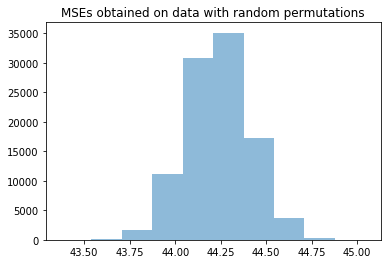

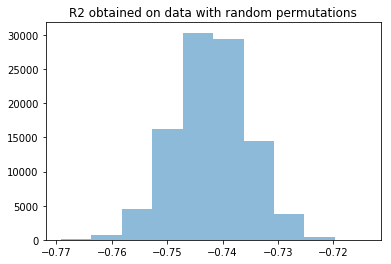

In [52]:
plt.hist(train_perm_mse, alpha=0.5)
plt.title('MSEs obtained on data with random permutations')
plt.show()
plt.hist(train_perm_r2, alpha=0.5)
plt.title('R2 obtained on data with random permutations')
plt.show()

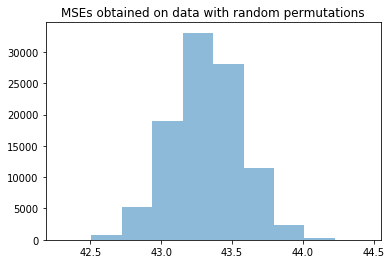

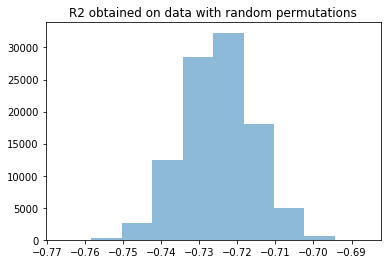

In [53]:
plt.hist(test_perm_mse, alpha=0.5)
plt.title('MSEs obtained on data with random permutations')
plt.show()
plt.hist(test_perm_r2, alpha=0.5)
plt.title('R2 obtained on data with random permutations')
plt.show()

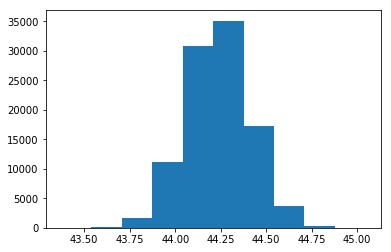

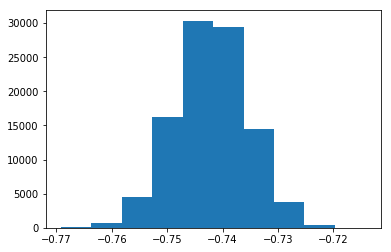

In [54]:
plt.hist(train_perm_mse)
plt.show()
plt.hist(train_perm_r2)
plt.show()

In [55]:
tc

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, gamma=0, learning_rate=0.05, max_delta_step=0,
       max_depth=15, min_child_weight=1, missing=nan, n_estimators=100,
       n_jobs=1, nthread=None, objective='reg:linear', random_state=0,
       reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
       silent=True, subsample=0.5)

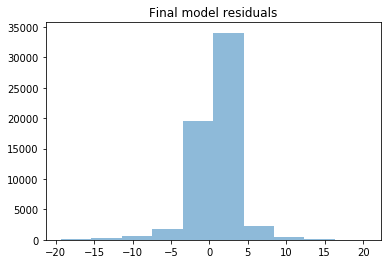

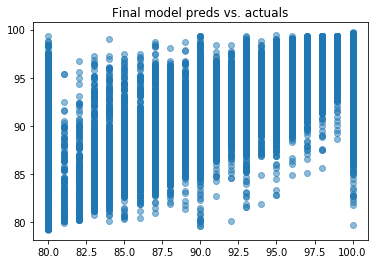

In [56]:
yv['preds'] = Xvp
s = yv
plt.hist(s.review_scores_rating - s.preds, alpha=0.5)
plt.title('Final model residuals')
plt.show()
plt.scatter(s.review_scores_rating, s.preds, alpha=0.5)
plt.title('Final model preds vs. actuals')
plt.show()

In [57]:
yv.to_csv('./data/user_stack_preds.csv', encoding='utf8')

In [59]:
comb_train.shape

(119615, 72)